## 1. Imports and Constants

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

TRAIN_FILE_PATH = '/content/drive/My Drive/market_approvability_train.csv'
TEST_FILE_PATH = '/content/drive/MyDrive/market_approvability_test.csv'
CHEMBERTA_MODEL_NAME = "DeepChem/ChemBERTa-77M-MLM"
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
RANDOM_STATE = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Data Loading

In [ ]:
df_train = pd.read_csv(TRAIN_FILE_PATH, usecols=['smiles', 'label'])
smiles_train = df_train['smiles'].tolist()
labels_train = df_train['label'].tolist()
df_test = pd.read_csv(TEST_FILE_PATH, usecols=['smiles', 'label'])
smiles_test = df_test['smiles'].tolist()
labels_test = df_test['label'].tolist()

## 3. ChemBERTa Model Setup

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(CHEMBERTA_MODEL_NAME)
chemberta_model = AutoModel.from_pretrained(CHEMBERTA_MODEL_NAME).to(device).eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.26k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4. Data Preparation

In [ ]:
# Tokenize and encode training data
encoded_train = tokenizer(smiles_train, padding=True, truncation=True, return_tensors="pt", max_length=512)
input_ids_train = encoded_train['input_ids'].to(device)
attention_mask_train = encoded_train['attention_mask'].to(device)
train_dataset = TensorDataset(input_ids_train, attention_mask_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 5. Embeddings Generation

In [ ]:
# Generate embeddings for training data
train_embeddings = []
for input_ids, attention_mask in tqdm(train_loader, desc="Generating Embeddings"):
    with torch.no_grad():
        outputs = chemberta_model(input_ids=input_ids, attention_mask=attention_mask)
        embedding = outputs.last_hidden_state.mean(dim=1)
        train_embeddings.append(embedding)
train_embeddings = torch.cat(train_embeddings, dim=0).to(device)

Generating Embeddings: 100%|██████████| 264/264 [00:05<00:00, 45.97it/s]


## 6. MLP Model Definition

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MLPClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 1024), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, 8), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(8, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

## 7. MLP Model Training

In [ ]:
model = MLPClassifier(train_embeddings.shape[1]).to(device)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()
features_train = train_embeddings
labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).to(device)
train_dataset = TensorDataset(features_train, labels_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model.train()
for epoch in range(NUM_EPOCHS):
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.6025538444519043
Epoch 2, Loss: 0.5347976684570312
Epoch 3, Loss: 0.5760443210601807
Epoch 4, Loss: 0.5417767763137817
Epoch 5, Loss: 0.5051797032356262
Epoch 6, Loss: 0.5610082149505615
Epoch 7, Loss: 0.3280755281448364
Epoch 8, Loss: 0.3447575569152832
Epoch 9, Loss: 0.4980284571647644
Epoch 10, Loss: 0.2881835103034973


## 8. Data Resampling

In [ ]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_res, y_res = ros.fit_resample(train_embeddings.cpu().numpy(), labels_train)
features_resampled = torch.tensor(X_res, dtype=torch.float32).to(device)
labels_resampled = torch.tensor(y_res, dtype=torch.float32).to(device)

resampled_dataset = TensorDataset(features_resampled, labels_resampled)
resampled_loader = DataLoader(resampled_dataset, batch_size=BATCH_SIZE, shuffle=True)

## 9. MLP Model Training on Resampled Data

In [ ]:
model_resampled = MLPClassifier(train_embeddings.shape[1]).to(device)
optimizer_resampled = Adam(model_resampled.parameters(), lr=LEARNING_RATE)

model_resampled.train()
for epoch in range(NUM_EPOCHS):
    for features, targets in resampled_loader:
        optimizer_resampled.zero_grad()
        outputs = model_resampled(features).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_resampled.step()
    print(f'Resampled Epoch {epoch+1}, Loss: {loss.item()}')

Resampled Epoch 1, Loss: 0.6399387121200562
Resampled Epoch 2, Loss: 0.5879583358764648
Resampled Epoch 3, Loss: 0.6872209310531616
Resampled Epoch 4, Loss: 0.5355926156044006
Resampled Epoch 5, Loss: 0.42017897963523865
Resampled Epoch 6, Loss: 0.31125447154045105
Resampled Epoch 7, Loss: 0.39842018485069275
Resampled Epoch 8, Loss: 0.2460978627204895
Resampled Epoch 9, Loss: 0.503314733505249
Resampled Epoch 10, Loss: 0.3072618544101715


## 10. Evaluation

In [ ]:
# Prepare test data embeddings
encoded_test = tokenizer(smiles_test, padding=True, truncation=True, return_tensors="pt", max_length=512)
input_ids_test = encoded_test['input_ids'].to(device)
attention_mask_test = encoded_test['attention_mask'].to(device)

test_loader = DataLoader(TensorDataset(input_ids_test, attention_mask_test), batch_size=BATCH_SIZE, shuffle=False)
test_embeddings = []
chemberta_model.eval()
with torch.no_grad():
    for input_ids, attention_mask in test_loader:
        outputs = chemberta_model(input_ids=input_ids, attention_mask=attention_mask)
        embedding = outputs.last_hidden_state.mean(dim=1)
        test_embeddings.append(embedding)
test_embeddings = torch.cat(test_embeddings, dim=0).to(device)

features_test = test_embeddings
prediction_loader_test = DataLoader(features_test, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Functions to evaluate the model
def plot_confusion_matrix(true_labels, predicted_labels, title='Confusion Matrix'):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

def evaluate_model(model, loader, labels_test):
    model.eval()
    predictions = []
    with torch.no_grad():
        for features in loader:
            outputs = model(features).squeeze()
            predicted_labels = (outputs >= 0.5).long()
            predictions.extend(predicted_labels.cpu().numpy())

    accuracy = accuracy_score(labels_test, predictions)
    precision = precision_score(labels_test, predictions)
    recall = recall_score(labels_test, predictions)
    f1 = f1_score(labels_test, predictions)
    roc_auc = roc_auc_score(labels_test, [x.item() for x in predictions])

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    plot_confusion_matrix(labels_test, predictions, title='Confusion Matrix for MLPClassifier')

Evaluating Original Model:
Accuracy: 0.7401490947816827
Precision: 0.806640625
Recall: 0.7401433691756273
F1 Score: 0.7719626168224301
ROC AUC: 0.7401504247452939


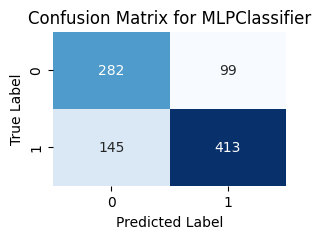

Evaluating Resampled Model:
Accuracy: 0.7614483493077743
Precision: 0.7982142857142858
Recall: 0.8010752688172043
F1 Score: 0.7996422182468694
ROC AUC: 0.7522436711540089


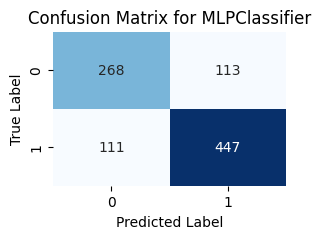

In [ ]:
# Evaluate models
print("Evaluating Original Model:")
evaluate_model(model, prediction_loader_test, labels_test)
print("========================================================================")
print("Evaluating Resampled Model:")
evaluate_model(model_resampled, prediction_loader_test, labels_test)